# Imports

In [ ]:
%%capture
!pip install yfinance

In [ ]:
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import copy
import pandas_datareader as pdr
import numpy as np
import matplotlib.ticker as ticker

# Helpers

In [ ]:
def add_dividends(hist, div):
  hist["Dividends"] = 0.0
  
  for i, r in div.iterrows():
    hist.loc[
        (hist["Date"].dt.month == r["Date"].month) &
        (hist["Date"].dt.year == r["Date"].year), 
        "Dividends"
    ] = r["Dividends"]

  hist["c"] = hist["Close"] + hist["Dividends"]

  return hist

def add_portfolio_value(df, start=1000000.0):
  df.reset_index(drop=True, inplace=True)
  df["portfolio"] = 10000.0
  
  for i, r in df.iterrows():
    if i == 0:
      df.at[i, "portfolio"] = start * (1 + r["ret"])
    else:
      df.at[i, "portfolio"] = df["portfolio"].iloc[i - 1] * (1 + r["ret"])

  return df

def add_half_monthly_ret(monthly_df, daily_df):
  monthly_df.reset_index(drop=True, inplace=True)

  for i, r in monthly_df.iterrows():
    temp = daily_df[
        (daily_df["Date"].dt.year == r["Date"].year) &
        (daily_df["Date"].dt.month == r["Date"].month)
    ]

    monthly_df.at[i, "Open_15"] = temp["Open"].iloc[0]

  return monthly_df

def convert_to_monthly_yield(monthly_df, daily_df):
  yields_df = pd.DataFrame()

  for i, r in monthly_df.iterrows():
    # print(f"{r['DATE']}")
    temp_df = daily_df[
        (daily_df["DATE"].dt.year == r["DATE"].year) & 
        (daily_df["DATE"].dt.month == r["DATE"].month)
    ]

    if temp_df.shape[0] > 0:
      yields_df = pd.concat([
          yields_df, 
          pd.DataFrame({
              "DATE": [r["DATE"]], 
              "yield": temp_df["yield"].iloc[-1]
          })
      ], ignore_index=True)

  return yields_df

def convert_np_dt_to_python_dt(dts):
  converted_dts = []

  for dt in dts:
    dt64 = np.datetime64(dt)
    ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    converted_dts.append(datetime.utcfromtimestamp(ts))

  return converted_dts

def add_last_dom(trades_df, spy_daily_df):
  months = convert_np_dt_to_python_dt(trades_df["Date"].unique())

  for m in months:
    temp_daily_df = spy_daily_df[
        (spy_daily_df["Date"].dt.year == m.year) &
        (spy_daily_df["Date"].dt.month == m.month)
    ]

    trades_df.loc[
        (trades_df["Date"].dt.year == m.year) &
        (trades_df["Date"].dt.month == m.month), 
        "Date Out"
    ] = temp_daily_df["Date"].iloc[-1]

  return trades_df

def add_features(df):
  df["c_1"] = df["c"].shift(1)
  df["o_1"] = df["Open"].shift(1)
  df["o_3"] = df["Open"].shift(3)
  df["o_6"] = df["Open"].shift(6)
  df["o_12"] = df["Open"].shift(12)

  df["ret"] = (df["c"] - df["Open"]) / df["Open"]
  df["ret_1"] = (df["c_1"] - df["o_1"]) / df["o_1"]
  df["ret_3"] = (df["c_1"] - df["o_3"]) / df["o_3"]
  df["ret_6"] = (df["c_1"] - df["o_6"]) / df["o_6"]
  df["ret_12"] = (df["c_1"] - df["o_12"]) / df["o_12"]

  df["p"] = ((12 * df["ret_1"]) + (4 * df["ret_3"]) + (2 * df["ret_6"]) + (df["ret_12"]) - 0.19)

  df["cum_ret"] = df["ret"].cumsum()
  df.dropna(inplace=True)
  df = add_portfolio_value(df)

  return df

# Data

In [ ]:
dfs_dict = {}

spy = yf.Ticker("SPY") #S&P 500
spy_df = yf.download("SPY", start="2003-10-01", end="2023-03-31", interval="1mo")
spy_df.dropna(inplace=True)
spy_df.reset_index(inplace=True)

spy_div = spy.dividends.to_frame().reset_index()
spy_df = add_dividends(spy_df, spy_div)

spy_df = add_features(spy_df)
dfs_dict["SPY"] = spy_df

iwm = yf.Ticker("IWM") # Russel 2000, Small Cap
iwm_df = yf.download("IWM", start="2003-10-01", end="2023-03-31", interval="1mo")
iwm_df.dropna(inplace=True)
iwm_df.reset_index(inplace=True)

iwm_div = iwm.dividends.to_frame().reset_index()
iwm_df = add_dividends(iwm_df, iwm_div)

iwm_df = add_features(iwm_df)
dfs_dict["IWM"] = iwm_df

qqq = yf.Ticker("QQQ") # NASDAQ
qqq_df = yf.download("QQQ", start="2003-10-01", end="2023-03-31", interval="1mo")
qqq_df.dropna(inplace=True)
qqq_df.reset_index(inplace=True)

qqq_div = qqq.dividends.to_frame().reset_index()
qqq_df = add_dividends(qqq_df, qqq_div)

qqq_df = add_features(qqq_df)
dfs_dict["QQQ"] = qqq_df

vgk = yf.Ticker("VGK") # FTSE Europe, Large Cap.
vgk_df = yf.download("VGK", start="2003-10-01", end="2023-03-31", interval="1mo")
vgk_df.dropna(inplace=True)
vgk_df.reset_index(inplace=True)

vgk_div = vgk.dividends.to_frame().reset_index()
vgk_df = add_dividends(vgk_df, vgk_div)

vgk_df = add_features(vgk_df)
dfs_dict["VGK"] = vgk_df

ewj = yf.Ticker("EWJ") # Equity, Japan, Large Cap.
ewj_df = yf.download("EWJ", start="2003-10-01", end="2023-03-31", interval="1mo")
ewj_df.dropna(inplace=True)
ewj_df.reset_index(inplace=True)

ewj_div = ewj.dividends.to_frame().reset_index()
ewj_df = add_dividends(ewj_df, ewj_div)

ewj_df = add_features(ewj_df)
dfs_dict["EWJ"] = ewj_df

eem = yf.Ticker("EEM") # Equity, Emerging Markets, Large Cap.
eem_df = yf.download("EEM", start="2003-10-01", end="2023-03-31", interval="1mo")
eem_df.dropna(inplace=True)
eem_df.reset_index(inplace=True)

eem_div = eem.dividends.to_frame().reset_index()
eem_df = add_dividends(eem_df, eem_div)

eem_df = add_features(eem_df)
dfs_dict["EEM"] = eem_df

vnq = yf.Ticker("VNQ") # Real Estate, US.
vnq_df = yf.download("VNQ", start="2003-10-01", end="2023-03-31", interval="1mo")
vnq_df.dropna(inplace=True)
vnq_df.reset_index(inplace=True)

vnq_div = vnq.dividends.to_frame().reset_index()
vnq_df = add_dividends(vnq_df, vnq_div)

vnq_df = add_features(vnq_df)
dfs_dict["VNQ"] = vnq_df

dbc = yf.Ticker("DBC") # Commodities, Diversified.
dbc_df = yf.download("DBC", start="2003-10-01", end="2023-03-31", interval="1mo")
dbc_df.dropna(inplace=True)
dbc_df.reset_index(inplace=True)

dbc_div = dbc.dividends.to_frame().reset_index()
dbc_df = add_dividends(dbc_df, dbc_div)

dbc_df = add_features(dbc_df)
dfs_dict["DBC"] = dbc_df

gld = yf.Ticker("GLD") # Gold
gld_df = yf.download("GLD", start="2003-10-01", end="2023-03-31", interval="1mo")
gld_df.dropna(inplace=True)
gld_df.reset_index(inplace=True)

gld_div = gld.dividends.to_frame().reset_index()
gld_df = add_dividends(gld_df, gld_div)

gld_df = add_features(gld_df)
dfs_dict["GLD"] = gld_df

tlt = yf.Ticker("TLT") # Gold
tlt_df = yf.download("TLT", start="2003-10-01", end="2023-03-31", interval="1mo")
tlt_df.dropna(inplace=True)
tlt_df.reset_index(inplace=True)

tlt_div = tlt.dividends.to_frame().reset_index()
tlt_df = add_dividends(tlt_df, tlt_div)

tlt_df = add_features(tlt_df)
dfs_dict["TLT"] = tlt_df

hyg = yf.Ticker("HYG") # High Yield Corporate Bonds
hyg_df = yf.download("HYG", start="2003-10-01", end="2023-03-31", interval="1mo")
hyg_df.dropna(inplace=True)
hyg_df.reset_index(inplace=True)

hyg_div = hyg.dividends.to_frame().reset_index()
hyg_df = add_dividends(hyg_df, hyg_div)

hyg_df = add_features(hyg_df)
dfs_dict["HYG"] = hyg_df

lqd = yf.Ticker("LQD") # Investment Grade Corporate Bonds
lqd_df = yf.download("LQD", start="2003-10-01", end="2023-03-31", interval="1mo")
lqd_df.dropna(inplace=True)
lqd_df.reset_index(inplace=True)

lqd_div = lqd.dividends.to_frame().reset_index()
lqd_df = add_dividends(lqd_df, lqd_div)

lqd_df = add_features(lqd_df)
dfs_dict["LQD"] = lqd_df

shy = yf.Ticker("SHY") # US Treasuries, 1-3 Years
shy_df = yf.download("SHY", start="2003-10-01", end="2023-03-31", interval="1mo")
shy_df.dropna(inplace=True)
shy_df.reset_index(inplace=True)

shy_div = shy.dividends.to_frame().reset_index()
shy_df = add_dividends(shy_df, shy_div)

shy_df = add_features(shy_df)
dfs_dict["SHY"] = shy_df

ief = yf.Ticker("IEF") # US Treasuries, 7-10 Years
ief_df = yf.download("IEF", start="2003-10-01", end="2023-03-31", interval="1mo")
ief_df.dropna(inplace=True)
ief_df.reset_index(inplace=True)

ief_div = ief.dividends.to_frame().reset_index()
ief_df = add_dividends(ief_df, ief_div)

ief_df = add_features(ief_df)
dfs_dict["IEF"] = ief_df

bil = yf.Ticker("BIL") # US Treasuries, 1-3 Months
bil_df = yf.download("BIL", start="2003-10-01", end="2023-03-31", interval="1mo")
bil_df.dropna(inplace=True)
bil_df.reset_index(inplace=True)

bil_div = bil.dividends.to_frame().reset_index()
bil_df = add_dividends(bil_df, bil_div)

bil_df = add_features(bil_df)
dfs_dict["BIL"] = bil_df

agg = yf.Ticker("AGG") # US Aggregate Bonds
agg_df = yf.download("AGG", start="2003-10-01", end="2023-03-31", interval="1mo")
agg_df.dropna(inplace=True)
agg_df.reset_index(inplace=True)

agg_div = agg.dividends.to_frame().reset_index()
agg_df = add_dividends(agg_df, agg_div)

agg_df = add_features(agg_df)
dfs_dict["AGG"] = agg_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Defensive Asset Allocation - Backtest [Paper] (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3212862

## Risky Assets
> ### Equities

>*   SPY (S&P 500) (US, Equity - Large Cap)
>*   QQQ (Nasdaq 100) (US, Equity - Large Cap)
>*   IWM (Russel 2000) (US, Equity - Small Cap)
>*   VGK (FTSE 100) (Europe, Equity - Large Cap)
>*   EWJ (Nikkei 225) (Japan, Equity - Large Cap)
>*   EEM (Emerging Markets, Equity - Large Cap)

> ### Bonds

>*   TLT (US, Treasury Bonds - 20+ Years) (AAA Credit)
>*   HYG (US, High Yield Corporate Bonds - 3-10 Years) (BB - CCC Credit)

> ### Commodities & Others

>*   DBC (Diversified, Commodities)
>*   GLD (Gold, Commodities)
>*   VNQ (US, Real Estate)

## Safe Assets
> ### Bonds
>*   SHY (US, Treasury Bonds - 1-3 Years) (AAA Credit)
>*   IEF (US, Treasury Bonds - 7-10 Years) (AAA Credit)
>*   LQD (US, Investment Grade Corporate Bonds - 3-20+ Years) (AAA - BBB Credit)

## Canary Assets
> ### Equities
>* EEM (Emerging Markets, Equity - Large Cap)

> ### Bonds

>* AGG (US, Treasury/Corporate Bonds - 1-20 Years) (AAA - BBB Credit)


## Helpers

In [ ]:
def get_canary_assets_neg_score(eem, agg):
  # print(eem)
  if eem["p"].iloc[0] < 0 and \
  agg["p"].iloc[0] < 0:
    return 2
  
  elif eem["p"].iloc[0] < 0 or \
  agg["p"].iloc[0] < 0:
    return 1
  
  else:
    return 0

def get_top_risky_assets(dfs_dict, dt):
  # print(dt)
  risky_assets = [
      "SPY", "IWM", "QQQ", "VGK", "EWJ", "EEM", "VNQ", 
      "DBC", "GLD", "TLT", "HYG", "LQD"
  ]
  assets_dict = {
      "asset": [], 
      "score": []
  }

  # assets_df = pd.DataFrame()

  for k, v in dfs_dict.items():
    if k in risky_assets:
      temp = v[v["Date"].dt.date == dt.date()].copy()
      # print(k)

      if temp.shape[0] > 0:
        assets_dict["asset"].append(k)
        assets_dict["score"].append(temp["p"].iloc[0])

  assets_df = pd.DataFrame(assets_dict).sort_values(by="score", 
                                                    ignore_index=True, 
                                                    ascending=False)

  return assets_df["asset"][:6].values.tolist()

def get_top_safe_asset(dfs_dict, dt):
  safe_assets = [
      "SHY", "IEF", "LQD"
  ]
  assets_dict = {
      "asset": [], 
      "score": []
  }

  # assets_df = pd.DataFrame()

  for k, v in dfs_dict.items():
    if k in safe_assets:
      temp = v[v["Date"].dt.date == dt.date()].copy()

      assets_dict["asset"].append(k)
      assets_dict["score"].append(temp["p"].iloc[0])

  assets_df = pd.DataFrame(assets_dict).sort_values(by="score", 
                                                    ignore_index=True, 
                                                    ascending=False)

  return assets_df["asset"].iloc[0]

## Backtest

In [ ]:
def backtest():
  def_df = pd.DataFrame()

  for i, r in spy_df.iterrows():
    # print(r["Date"])
    temp_eem_df = dfs_dict["EEM"]
    temp_agg_df = dfs_dict["AGG"]

    # print(temp_eem_df[temp_eem_df["Date"] == r["Date"]])
    # print(temp_agg_df[temp_agg_df["Date"] == r["Date"]])

    canary_score = get_canary_assets_neg_score(
        eem=temp_eem_df[temp_eem_df["Date"] == r["Date"]], 
        agg=temp_agg_df[temp_agg_df["Date"] == r["Date"]]
    )

    temp_dfs_dict = {}

    for k, v in dfs_dict.items():
      temp_dfs_dict[k] = v[
          v["Date"] == r["Date"]
      ]

    if canary_score == 0:
      risky_assets = get_top_risky_assets(dfs_dict, r["Date"])

      ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.166) + \
      (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.166) + \
      (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.166) + \
      (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.166) + \
      (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.166) + \
      (temp_dfs_dict[risky_assets[5]]["ret"].iloc[0] * 0.166)

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [canary_score], 
              "holdings": [risky_assets]
          })
      ], ignore_index=True)
    elif canary_score == 1:
      risky_assets = get_top_risky_assets(dfs_dict, r["Date"])
      safe_asset = get_top_safe_asset(dfs_dict, r["Date"])

      if len(risky_assets) >= 6:
        ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.0833) + \
        (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.0833) + \
        (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.0833) + \
        (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.0833) + \
        (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.0833) + \
        (temp_dfs_dict[risky_assets[5]]["ret"].iloc[0] * 0.0833) + \
        (temp_dfs_dict[safe_asset]["ret"].iloc[0] * 0.5)
      else:
        ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.1) + \
        (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.1) + \
        (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.1) + \
        (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.1) + \
        (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.1) + \
        (temp_dfs_dict[safe_asset]["ret"].iloc[0] * 0.5)

      risky_assets.append(safe_asset)

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [canary_score], 
              "holdings": [risky_assets]
          })
      ], ignore_index=True)
    else:
      safe_asset = get_top_safe_asset(dfs_dict, r["Date"])

      ret = temp_dfs_dict[safe_asset]["ret"].iloc[0]

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [canary_score], 
              "holdings": [[safe_asset]]
          })
      ], ignore_index=True)

  return def_df

In [ ]:
daa_df = backtest()
daa_df["cum_ret"] = daa_df["ret"].cumsum()
daa_df = add_portfolio_value(daa_df)

# Vigilant Asset Allocation

## Helpers

In [ ]:
def get_num_of_neg_momentum_assets(dfs_dict, dt):
  risky_assets = [
      "SPY", "IWM", "QQQ", "VGK", "EWJ", "EEM", "VNQ", 
      "DBC", "GLD", "TLT", "HYG", "LQD"
  ]
  assets_dict = {
      "asset": [], 
      "score": []
  }

  for k, v in dfs_dict.items():
    if k in risky_assets:
      temp = v[v["Date"].dt.date == dt.date()].copy()
      # print(k)

      if temp.shape[0] > 0:
        assets_dict["asset"].append(k)
        assets_dict["score"].append(temp["p"].iloc[0])

  assets_df = pd.DataFrame(assets_dict).sort_values(by="score", 
                                                    ignore_index=True, 
                                                    ascending=False)
  
  return assets_df[
      assets_df["score"] < 0
  ].shape[0]

def get_top_risky_assets(dfs_dict, dt):
  # print(dt)
  risky_assets = [
      "SPY", "IWM", "QQQ", "VGK", "EWJ", "EEM", "VNQ", 
      "DBC", "GLD", "TLT", "HYG", "LQD"
  ]
  assets_dict = {
      "asset": [], 
      "score": []
  }

  # assets_df = pd.DataFrame()

  for k, v in dfs_dict.items():
    if k in risky_assets:
      temp = v[v["Date"].dt.date == dt.date()].copy()
      # print(k)

      if temp.shape[0] > 0:
        assets_dict["asset"].append(k)
        assets_dict["score"].append(temp["p"].iloc[0])

  assets_df = pd.DataFrame(assets_dict).sort_values(by="score", 
                                                    ignore_index=True, 
                                                    ascending=False)

  return assets_df["asset"][:5].values.tolist()

def get_top_safe_asset(dfs_dict, dt):
  safe_assets = [
      "BIL", "IEF", "LQD"
  ]

  assets_dict = {
      "asset": [], 
      "score": []
  }

  # assets_df = pd.DataFrame()

  for k, v in dfs_dict.items():
    if k in safe_assets:
      temp = v[v["Date"].dt.date == dt.date()].copy()

      if temp.shape[0] > 0:
        assets_dict["asset"].append(k)
        assets_dict["score"].append(temp["p"].iloc[0])

  assets_df = pd.DataFrame(assets_dict).sort_values(by="score", 
                                                    ignore_index=True, 
                                                    ascending=False)

  return assets_df["asset"].iloc[0]

## Backtest

In [ ]:
def backtest_vaa():
  def_df = pd.DataFrame()

  for i, r in spy_df.iterrows():
    neg_score = get_num_of_neg_momentum_assets(
        dfs_dict, 
        r["Date"]
    )

    temp_dfs_dict = {}

    for k, v in dfs_dict.items():
      temp_dfs_dict[k] = v[
          v["Date"] == r["Date"]
      ]

    if neg_score == 0:
      risky_assets = get_top_risky_assets(dfs_dict, r["Date"])

      ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.2) + \
      (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.2) + \
      (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.2) + \
      (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.2) + \
      (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.2)

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "neg_score": [neg_score], 
              "holdings": [risky_assets]
          })
      ], ignore_index=True)
    elif neg_score == 1:
      risky_assets = get_top_risky_assets(dfs_dict, r["Date"])
      safe_asset = get_top_safe_asset(dfs_dict, r["Date"])

      ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.15) + \
      (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.15) + \
      (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.15) + \
      (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.15) + \
      (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.15) + \
      (temp_dfs_dict[safe_asset]["ret"].iloc[0] * 0.25)

      risky_assets.append(safe_asset)

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [neg_score], 
              "holdings": [risky_assets]
          })
      ], ignore_index=True)
    elif neg_score == 2:
      risky_assets = get_top_risky_assets(dfs_dict, r["Date"])
      safe_asset = get_top_safe_asset(dfs_dict, r["Date"])

      ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.1) + \
      (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.1) + \
      (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.1) + \
      (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.1) + \
      (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.1) + \
      (temp_dfs_dict[safe_asset]["ret"].iloc[0] * 0.5)

      risky_assets.append(safe_asset)

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [neg_score], 
              "holdings": [risky_assets]
          })
      ], ignore_index=True)
    elif neg_score == 3:
      risky_assets = get_top_risky_assets(dfs_dict, r["Date"])
      safe_asset = get_top_safe_asset(dfs_dict, r["Date"])

      ret = (temp_dfs_dict[risky_assets[0]]["ret"].iloc[0] * 0.05) + \
      (temp_dfs_dict[risky_assets[1]]["ret"].iloc[0] * 0.05) + \
      (temp_dfs_dict[risky_assets[2]]["ret"].iloc[0] * 0.05) + \
      (temp_dfs_dict[risky_assets[3]]["ret"].iloc[0] * 0.05) + \
      (temp_dfs_dict[risky_assets[4]]["ret"].iloc[0] * 0.05) + \
      (temp_dfs_dict[safe_asset]["ret"].iloc[0] * 0.75)

      risky_assets.append(safe_asset)

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [neg_score], 
              "holdings": [risky_assets]
          })
      ], ignore_index=True)
    else:
      safe_asset = get_top_safe_asset(dfs_dict, r["Date"])

      ret = temp_dfs_dict[safe_asset]["ret"].iloc[0]

      def_df = pd.concat([
          def_df, 
          pd.DataFrame({
              "Date": [r["Date"]], 
              "ret": [ret], 
              "canary_score": [neg_score], 
              "holdings": [[safe_asset]]
          })
      ], ignore_index=True)

  return def_df

In [ ]:
vaa_df = backtest_vaa()
vaa_df["cum_ret"] = vaa_df["ret"].cumsum()
vaa_df = add_portfolio_value(vaa_df)

# Analysis

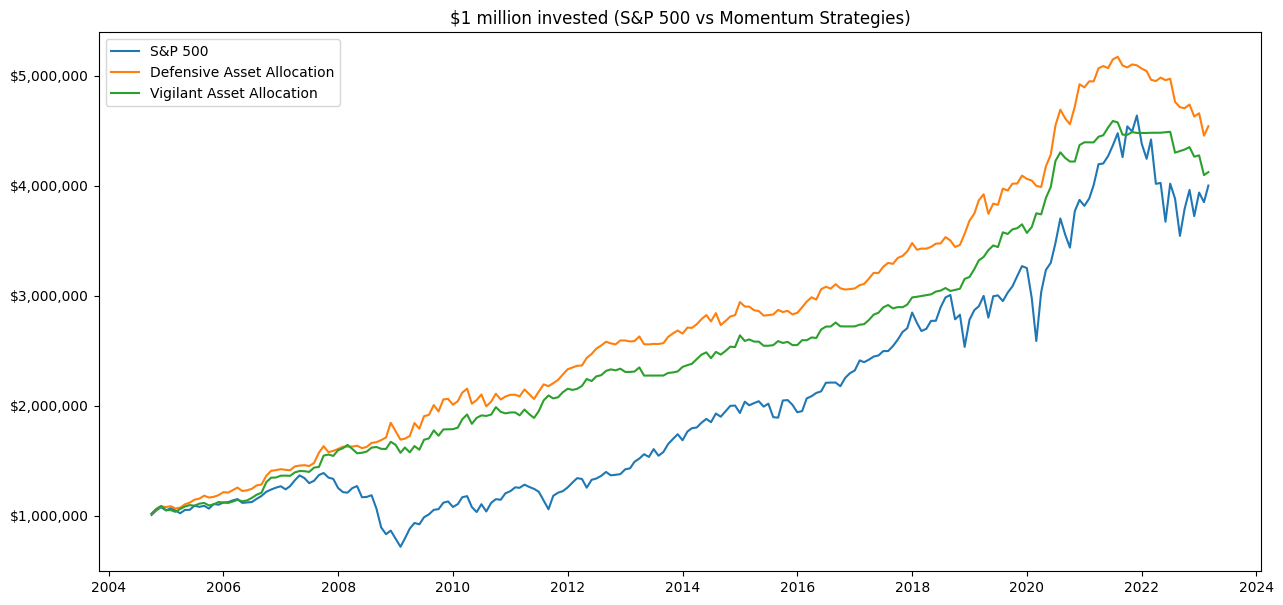

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 7))

ax.set_title("$1 million invested (S&P 500 vs Momentum Strategies)")
ax.plot(spy_df["Date"], spy_df["portfolio"], label="S&P 500")
ax.plot(daa_df["Date"], daa_df["portfolio"], label="Defensive Asset Allocation")
ax.plot(vaa_df["Date"], vaa_df["portfolio"], label="Vigilant Asset Allocation")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) 


# plt.plot(iwm_df["Date"], iwm_df["portfolio"], label="Russel 2000, Small Cap.")
# plt.plot(qqq_df["Date"], qqq_df["portfolio"], label="NASDAQ")
# plt.plot(vgk_df["Date"], vgk_df["portfolio"], label="FTSE Europe, Large Cap.")
# plt.plot(ewj_df["Date"], ewj_df["portfolio"], label="Equity, Japan, Large Cap.")
# plt.plot(eem_df["Date"], eem_df["portfolio"], label="Equity, Emerging Market, Large Cap.")
# plt.plot(vnq_df["Date"], vnq_df["portfolio"], label="Real Estate, US")
# plt.plot(dbc_df["Date"], dbc_df["portfolio"], label="Commodities, Diversified")
# plt.plot(gld_df["Date"], gld_df["portfolio"], label="Gold")
# plt.plot(tlt_df["Date"], tlt_df["portfolio"], label="US Treasuries, 20+ Years")
# plt.plot(hyg_df["Date"], hyg_df["portfolio"], label="High Yield Corporate Bonds")
# plt.plot(lqd_df["Date"], lqd_df["portfolio"], label="Investment Grade Corporate Bonds")
# plt.plot(shy_df["Date"], shy_df["portfolio"], label="US Treasuries, 1-3 Years")
# plt.plot(ief_df["Date"], ief_df["portfolio"], label="US Treasuries, 7-10 Years")
# plt.plot(bil_df["Date"], bil_df["portfolio"], label="US Treasuries, 1-3 Months")
# plt.plot(agg_df["Date"], agg_df["portfolio"], label="US Aggregate Bonds")

plt.legend(loc="upper left")
# plt.savefig("SP_vs_Momo.png")
plt.show()

# Portfolio Metrics

In [ ]:
def get_rolling_annual_returns(df):
  ann_df = pd.DataFrame()
  df = df.reset_index(drop=True)
  
  for i in range(12, df.shape[0]):
    ann_df = pd.concat([
        ann_df,
        pd.DataFrame({
            "Date": [df["Date"].iloc[i]], 
            "ret": [(df["portfolio"].iloc[i] - df["portfolio"].iloc[i - 12]) / df["portfolio"].iloc[i - 12]]
        })
    ], ignore_index=True)

  return ann_df

def get_rolling_beta_df(trades_df, spy_df, months=12):
  ann_df = pd.DataFrame()

  for i in range(months, trades_df.shape[0]):
    temp_trades_df = trades_df[i - months:i]
    temp_spy_df = spy_df[i - months:i]

    if temp_trades_df.shape[0] > 0:
      beta = (temp_trades_df["ret"].cov(
          temp_spy_df["ret"]
      ) / temp_spy_df["ret"].var())

      ann_df = pd.concat([
          ann_df, 
          pd.DataFrame({
              "Date": [temp_spy_df["Date"].iloc[0]], 
              "beta": [beta]
          })
      ], ignore_index=True)

  return ann_df["beta"]

def get_rolling_beta_avg_df(trades_df, spy_df, months=12):
  ann_df = pd.DataFrame()

  for i in range(months, trades_df.shape[0]):
    temp_trades_df = trades_df[i - months:i]
    temp_spy_df = spy_df[i - months:i]

    if temp_trades_df.shape[0] > 0:
      beta = (temp_trades_df["ret"].cov(
          temp_spy_df["ret"]
      ) / temp_spy_df["ret"].var())

      ann_df = pd.concat([
          ann_df, 
          pd.DataFrame({
              "Date": [temp_spy_df["Date"].iloc[0]], 
              "beta": [beta]
          })
      ], ignore_index=True)

  return ann_df["beta"].mean()

def get_rolling_calmar_ratio(df, months=36):
  calmar_df = pd.DataFrame()

  for i in range(36, df.shape[0]):
    temp_df = copy.deepcopy(df[i - months:i])

    ann_ret = (temp_df["portfolio"].iloc[-1] - temp_df["portfolio"].iloc[0]) / temp_df["portfolio"].iloc[0]
    ann_ret = ann_ret / 3

    max_drawdown = temp_df["drawdown"].max()

    d = pd.DataFrame({
        "Date": [temp_df["Date"].iloc[-1]],
        "Calmar": [ann_ret / max_drawdown]
    })

    calmar_df = pd.concat([
        calmar_df, 
        d
    ], ignore_index=True)

  return calmar_df["Calmar"].mean()

def get_cvar(df, var_cutoff=0.01):
  return df[df["ret"] < df["ret"].quantile(var_cutoff)]["ret"].mean() * 100

In [ ]:
spy_df["max_portfolio"] = spy_df["portfolio"].cummax()
spy_df["drawdown"] = (spy_df["max_portfolio"] - spy_df["portfolio"]) / spy_df["max_portfolio"]

daa_df["max_portfolio"] = daa_df["portfolio"].cummax()
daa_df["drawdown"] = (daa_df["max_portfolio"] - daa_df["portfolio"]) / daa_df["max_portfolio"]

vaa_df["max_portfolio"] = vaa_df["portfolio"].cummax()
vaa_df["drawdown"] = (vaa_df["max_portfolio"] - vaa_df["portfolio"]) / vaa_df["max_portfolio"]

In [ ]:
sp_cagr = ((spy_df["portfolio"].iloc[-1] / 1000000) ** (1/18) - 1)
daa_df_cagr = ((daa_df["portfolio"].iloc[-1] / 1000000) ** (1/18) - 1)
vaa_df_cagr = ((vaa_df["portfolio"].iloc[-1] / 1000000) ** (1/18) - 1)

spy_ann = spy_df.groupby(spy_df["Date"].dt.year).sum()[["ret"]]
daa_df_ann = daa_df.groupby(daa_df["Date"].dt.year).sum()[["ret"]]
vaa_df_ann = vaa_df.groupby(vaa_df["Date"].dt.year).sum()[["ret"]]

sp_best_year = spy_ann["ret"].max()
daa_df_best_year = daa_df_ann["ret"].max()
vaa_df_best_year = vaa_df_ann["ret"].max()

sp_worst_year = spy_ann["ret"].min()
daa_df_worst_year = daa_df_ann["ret"].min()
vaa_df_worst_year = vaa_df_ann["ret"].min()

sp_ann_ret = spy_ann["ret"].mean()
daa_df_ann_ret = daa_df_ann["ret"].mean()
vaa_df_ann_ret = vaa_df_ann["ret"].mean()

sp_ann_vol = spy_ann["ret"].std()
daa_df_ann_vol = daa_df_ann["ret"].std()
vaa_df_ann_vol = vaa_df_ann["ret"].std()

sp_mon_VaR = spy_df["ret"].quantile(0.01)
daa_df_mon_VaR = daa_df["ret"].quantile(0.01)
vaa_df_mon_VaR = vaa_df["ret"].quantile(0.01)

sp_ann_roll = get_rolling_annual_returns(spy_df)
daa_df_ann_roll = get_rolling_annual_returns(daa_df)
vaa_df_ann_roll = get_rolling_annual_returns(vaa_df)

sp_ann_ret_roll = sp_ann_roll["ret"].mean()
daa_df_ann_ret_roll = daa_df_ann_roll["ret"].mean()
vaa_df_ann_ret_roll = vaa_df_ann_roll["ret"].mean()

sp_best_year_roll = sp_ann_roll["ret"].max()
daa_df_best_year_roll = daa_df_ann_roll["ret"].max()
vaa_df_best_year_roll = vaa_df_ann_roll["ret"].max()

sp_worst_year_roll = sp_ann_roll["ret"].min()
daa_df_worst_year_roll = daa_df_ann_roll["ret"].min()
vaa_df_worst_year_roll = vaa_df_ann_roll["ret"].min()

daa_beta = get_rolling_beta_avg_df(daa_df_ann_roll, sp_ann_roll)
vaa_beta = get_rolling_beta_avg_df(vaa_df_ann_roll, sp_ann_roll)

sp_calmar = get_rolling_calmar_ratio(spy_df)
daa_df_calmar = get_rolling_calmar_ratio(daa_df)
vaa_df_calmar = get_rolling_calmar_ratio(vaa_df)

sp_cvar = get_cvar(spy_df)
daa_df_cvar = get_cvar(daa_df)
vaa_df_cvar = get_cvar(vaa_df)

sp_sharpe = sp_ann_roll["ret"].mean() / sp_ann_roll["ret"].std()
daa_df_sharpe = daa_df_ann_roll["ret"].mean() / daa_df_ann_roll["ret"].std()
vaa_df_sharpe = vaa_df_ann_roll["ret"].mean() / vaa_df_ann_roll["ret"].std()

spy_ann_neg = copy.deepcopy(sp_ann_roll)
daa_df_ann_neg = copy.deepcopy(daa_df_ann_roll)
vaa_df_ann_neg = copy.deepcopy(vaa_df_ann_roll)

spy_ann_neg["ret"] = sp_ann_roll.apply(lambda x: x["ret"] if x["ret"] < 0 else 0, axis=1)
daa_df_ann_neg["ret"] = daa_df_ann_roll.apply(lambda x: x["ret"] if x["ret"] < 0 else 0, axis=1)
vaa_df_ann_neg["ret"] = vaa_df_ann_roll.apply(lambda x: x["ret"] if x["ret"] < 0 else 0, axis=1)

sp_sortino = sp_ann_roll["ret"].mean() / spy_ann_neg["ret"].std()
daa_df_sortino = daa_df_ann_roll["ret"].mean() / daa_df_ann_neg["ret"].std()
vaa_df_sortino = vaa_df_ann_roll["ret"].mean() / vaa_df_ann_neg["ret"].std()

sp_max_dd = spy_df["drawdown"].max()
daa_df_max_dd = daa_df["drawdown"].max()
vaa_df_max_dd = vaa_df["drawdown"].max()

sp_avg_dd = spy_df["drawdown"].mean()
daa_df_avg_dd = daa_df["drawdown"].mean()
vaa_df_avg_dd = vaa_df["drawdown"].mean()

sp_gfc = spy_df[(spy_df["Date"].dt.date >= date(2007, 10, 1)) &
                (spy_df["Date"].dt.date <= date(2009, 3, 1))]

daa_df_gfc = daa_df[(daa_df["Date"].dt.date >= date(2007, 10, 1)) &
                (daa_df["Date"].dt.date <= date(2009, 3, 1))]
vaa_df_gfc = vaa_df[(vaa_df["Date"].dt.date >= date(2007, 10, 1)) &
                (vaa_df["Date"].dt.date <= date(2009, 3, 1))]

sp_gfc_ret = (sp_gfc["portfolio"].iloc[-1] - sp_gfc["portfolio"].iloc[0]) / sp_gfc["portfolio"].iloc[0]
daa_df_gfc_ret = (daa_df_gfc["portfolio"].iloc[-1] - daa_df_gfc["portfolio"].iloc[0]) / daa_df_gfc["portfolio"].iloc[0]
vaa_df_gfc_ret = (vaa_df_gfc["portfolio"].iloc[-1] - vaa_df_gfc["portfolio"].iloc[0]) / vaa_df_gfc["portfolio"].iloc[0]


sp_covid = spy_df[(spy_df["Date"].dt.date >= date(2020, 1, 1)) &
                (spy_df["Date"].dt.date <= date(2020, 3, 1))]

daa_df_covid = daa_df[(daa_df["Date"].dt.date >= date(2020, 1, 1)) &
                (daa_df["Date"].dt.date <= date(2020, 3, 1))]
vaa_df_covid = vaa_df[(vaa_df["Date"].dt.date >= date(2020, 1, 1)) &
                (vaa_df["Date"].dt.date <= date(2020, 3, 1))]

sp_covid_ret = (sp_covid["portfolio"].iloc[-1] - sp_covid["portfolio"].iloc[0]) / sp_covid["portfolio"].iloc[0]
daa_df_covid_ret = (daa_df_covid["portfolio"].iloc[-1] - daa_df_covid["portfolio"].iloc[0]) / daa_df_covid["portfolio"].iloc[0]
vaa_df_covid_ret = (vaa_df_covid["portfolio"].iloc[-1] - vaa_df_covid["portfolio"].iloc[0]) / vaa_df_covid["portfolio"].iloc[0]

sp_2022 = spy_df[(spy_df["Date"].dt.date >= date(2022, 1, 1)) &
                (spy_df["Date"].dt.date <= date(2022, 11, 1))]

daa_df_2022 = daa_df[(daa_df["Date"].dt.date >= date(2022, 1, 1)) &
                (daa_df["Date"].dt.date <= date(2022, 11, 1))]
vaa_df_2022 = vaa_df[(vaa_df["Date"].dt.date >= date(2022, 1, 1)) &
                (vaa_df["Date"].dt.date <= date(2022, 11, 1))]

sp_2022_ret = (sp_2022["portfolio"].iloc[-1] - sp_2022["portfolio"].iloc[0]) / sp_2022["portfolio"].iloc[0]
daa_df_2022_ret = (daa_df_2022["portfolio"].iloc[-1] - daa_df_2022["portfolio"].iloc[0]) / daa_df_2022["portfolio"].iloc[0]
vaa_df_2022_ret = (vaa_df_2022["portfolio"].iloc[-1] - vaa_df_2022["portfolio"].iloc[0]) / vaa_df_2022["portfolio"].iloc[0]

sp_skew = spy_ann["ret"].skew()
daa_df_skew = daa_df_ann["ret"].skew()
vaa_df_skew = vaa_df_ann["ret"].skew()

<ipython-input-48-d7377f6b0b36>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  spy_ann = spy_df.groupby(spy_df["Date"].dt.year).sum()[["ret"]]
<ipython-input-48-d7377f6b0b36>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daa_df_ann = daa_df.groupby(daa_df["Date"].dt.year).sum()[["ret"]]
<ipython-input-48-d7377f6b0b36>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vaa_df_ann = vaa_df.groupby(vaa_df["Date"].dt.year

In [ ]:
metrics_df = pd.DataFrame({
    "Metric": ["CAGR", "Avg. Annual Returns", "Rolling 12M Avg Returns", 
               "Best Year", "Rolling 12M Best", "Worst Year", "Rolling 12M Worst",
               "Rolling 12M Avg. Beta", 
               "Rolling 12M Sharpe", "Rolling 12M Sortino", "Rolling 3Y Avg. Calmar Ratio",
               "Monthly VaR", "Monthly CVaR",
               "Annualized Volatilty", 
               "Skewness", "Max Drawdown", "Avg. Drawdown",
               "GFC Returns", "Covid Crash Returns", 
               "2022 YTD"],
    "S&P 500": [
        (sp_cagr * 100), 
        (sp_ann_ret * 100),
        (sp_ann_ret_roll * 100),
        (sp_best_year * 100),
        (sp_best_year_roll * 100),
        (sp_worst_year * 100),
        (sp_worst_year_roll * 100),
        (1),
        (sp_sharpe), 
        (sp_sortino), 
        (sp_calmar), 
        (sp_mon_VaR * 100),
        (sp_cvar),
        (sp_ann_vol * 100),
        (sp_skew),
        -(sp_max_dd * 100), 
        -(sp_avg_dd * 100),
        (sp_gfc_ret * 100), 
        (sp_covid_ret * 100), 
        (sp_2022_ret * 100)
    ], 
    "DAA": [
        (daa_df_cagr * 100), 
        (daa_df_ann_ret * 100),
        (daa_df_ann_ret_roll * 100),
        (daa_df_best_year * 100),
        (daa_df_best_year_roll * 100),
        (daa_df_worst_year * 100),
        (daa_df_worst_year_roll * 100),
        (daa_beta),
        (daa_df_sharpe), 
        (daa_df_sortino), 
        (daa_df_calmar), 
        (daa_df_mon_VaR * 100),
        (daa_df_cvar),
        (daa_df_ann_vol * 100),
        (daa_df_skew),
        -(daa_df_max_dd * 100), 
        -(daa_df_avg_dd * 100),
        (daa_df_gfc_ret * 100), 
        (daa_df_covid_ret * 100), 
        (daa_df_2022_ret * 100)
    ], 
    "VAA": [
        (vaa_df_cagr * 100), 
        (vaa_df_ann_ret * 100),
        (vaa_df_ann_ret_roll * 100),
        (vaa_df_best_year * 100),
        (vaa_df_best_year_roll * 100),
        (vaa_df_worst_year * 100),
        (vaa_df_worst_year_roll * 100),
        (vaa_beta),
        (vaa_df_sharpe), 
        (vaa_df_sortino), 
        (vaa_df_calmar), 
        (vaa_df_mon_VaR * 100),
        (vaa_df_cvar),
        (vaa_df_ann_vol * 100),
        (vaa_df_skew),
        -(vaa_df_max_dd * 100), 
        -(vaa_df_avg_dd * 100),
        (vaa_df_gfc_ret * 100), 
        (vaa_df_covid_ret * 100), 
        (vaa_df_2022_ret * 100)
    ]
})

In [ ]:
metrics_df

,Metric,S&P 500,DAA,VAA
0,CAGR,8.009343,8.771015,8.189860
1,Avg. Annual Returns,8.043388,7.833273,7.294910
2,Rolling 12M Avg Returns,8.829345,8.967112,8.515860
3,Best Year,29.317177,19.026833,18.472889
4,Rolling 12M Best,54.745479,27.045199,24.316778
5,Worst Year,-40.402810,-9.418215,-4.817145
6,Rolling 12M Worst,-40.863642,-11.647692,-8.551929
7,Rolling 12M Avg. Beta,1.000000,0.263500,0.147062
8,Rolling 12M Sharpe,0.589060,1.266552,1.246352
9,Rolling 12M Sortino,1.161729,5.361130,7.554094
